Batches:   0%|          | 0/154 [00:00<?, ?it/s]

(4926, 384)
(4926, 2)


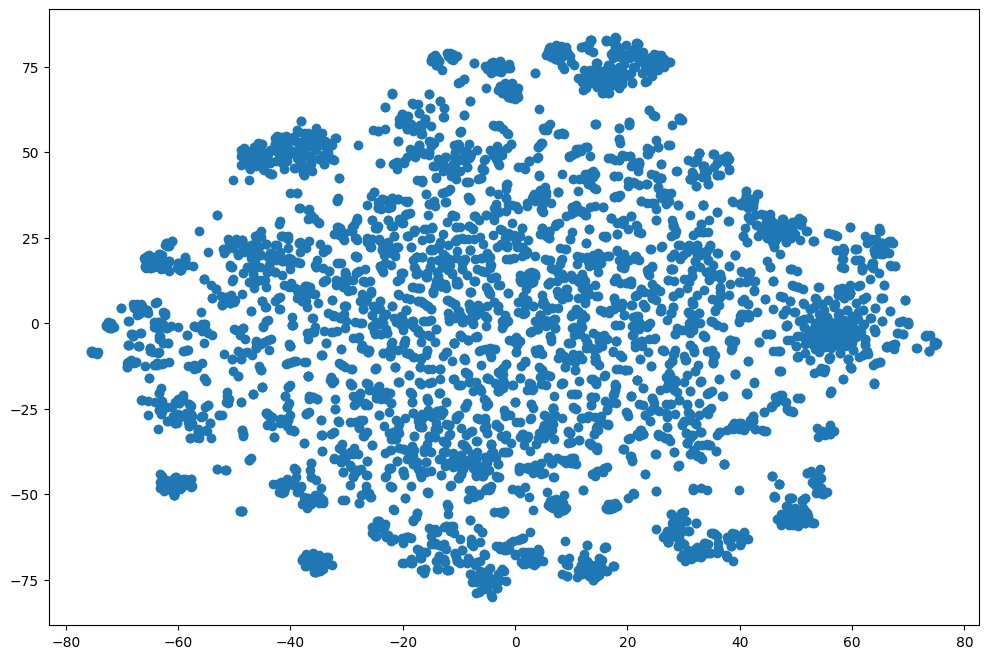

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
import json
import re
from datasets import load_dataset

# Load data
filename = "promptset"
dataset = load_dataset("pisterlabs/promptset")["train"].filter(lambda x: len(x["prompts"]) > 30)["prompts"]
strings = []
for prompt in dataset:
    strings.extend(prompt)
strings = list(set(strings))

# Step 1: Generate Embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(strings, show_progress_bar=True)
embeddings = np.array(embeddings)
print(embeddings.shape)

# Step 2: Reduce Dimensionality with t-SNE
tsne = TSNE(n_components=2)
embeddings_reduced = tsne.fit_transform(embeddings)
print(embeddings_reduced.shape)

# Step 3: Plotting
x_coords = embeddings_reduced[:, 0]
y_coords = embeddings_reduced[:, 1]
plt.figure(figsize=(12, 8))
plt.scatter(x_coords, y_coords)

### **Using K-Means to cluster the prompts**

1. Using an Elbow Plot to find the optimal number of clusters

In [2]:
# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# # Initialize the list to hold the within-cluster sum of square values
# wcss = []

# # We might want to test a range of k values; I'll choose from 1 to 15
# k_clusters = range(1, 50, 2)
# for i in k_clusters:
#     kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=500, n_init=10, random_state=0)
#     kmeans.fit(embeddings)
#     wcss.append(kmeans.inertia_)  # inertia_ is the WCSS for that model
#     if i % 10 == 0:
#         print(f'Finished {i} clusters')

# # Now time to craft our plot with elbow grease
# plt.figure(figsize=(12, 8))
# plt.plot(k_clusters, wcss, marker='o', linestyle='--')

# # Let's make it look top-notch, follow the material design principles for crisp visuals
# plt.title('Elbow Method to Determine Optimal Cluster Count')
# plt.xlabel('Number of clusters (k)')
# plt.xticks(k_clusters)
# plt.ylabel('Within-cluster Sum of Squares (WCSS)')
# plt.grid(True, which='both', linestyle='--', linewidth=0.7)
# plt.minorticks_on()
# plt.savefig(f"images/{filename}_elbow.png")
# plt.show()

2. Using K-Means with optimal number of clusters to cluster the prompts

/tmp/ipykernel_20440/1893032140.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors


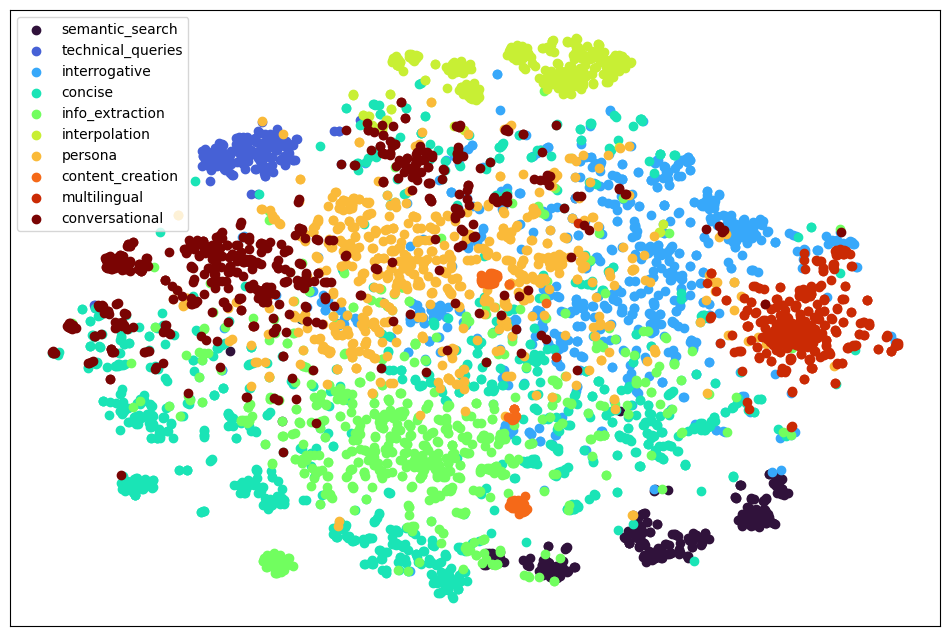

In [3]:
# Let's assume k_optimal is the optimal cluster count we selected from the elbow plot
k_optimal = 10  # Replace this with the actual optimal number of clusters you have observed
labels = ["semantic_search", "technical_queries", "interrogative", "concise", "info_extraction", "interpolation", "persona", "content_creation", "multilingual", "conversational"]

# Now run the K-Means algorithm with the optimal number of clusters
kmeans_optimal = KMeans(n_clusters=k_optimal, init='k-means++', max_iter=1000, n_init=10, random_state=0)
cluster_labels = kmeans_optimal.fit_predict(embeddings)

# Then we visualize using a palette that has a nice variety of distinct colors
palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors
plt.figure(figsize=(12, 8))

# Scatter plot with color coding for each cluster
for i in range(k_optimal):
    plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], label=labels[i], c=[palette(i)], alpha=1)

# Shining the spotlight on good design – a must for great UX
# plt.title('t-SNE Visualization of Sentence Embeddings with K-Means Clustering')
# plt.xlabel('t-SNE axis 1')
# plt.ylabel('t-SNE axis 2')
plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

# Add that crisp legend, positioned so it doesn’t smudge our plot
plt.legend()

# And display!
plt.savefig(f"images/{filename}_clusters.png")
plt.show()

In [4]:
# Make cluster to prompt map
cluster_to_prompt = {}
for i in range(k_optimal):
    cluster_to_prompt[i] = []
    for j in range(len(strings)):
        if cluster_labels[j] == i:
            cluster_to_prompt[i].append(strings[j])

# Save cluster to prompt map
import json
with open(f'data/cluster_to_prompt_{filename}.json', 'w') as f:
    json.dump(cluster_to_prompt, f)

### **Affinity Propagation Clustering Algorithm**

In [5]:
# from tqdm import tqdm

# # Run the Affinity Propagation algorithm 
# aff_prop = AffinityPropagation(damping=0.7)
# cluster_labels = aff_prop.fit_predict(embeddings)

# # Update k_optimal with the actual number of clusters found by Affinity Propagation
# k_optimal = len(set(cluster_labels))

# # Make sure labels correspond to the number of clusters
# labels = [f"label_{i}" for i in range(k_optimal)]

# # Now run the visualization using the cluster labels resulting from Affinity Propagation
# palette = plt.cm.get_cmap('turbo', k_optimal)  # 'tab10' provides nice distinct colors
# plt.figure(figsize=(12, 8))

# # Scatter plot with color coding for each cluster
# for i in tqdm(range(k_optimal)):
#     plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], label=labels[i], c=[palette(i)], alpha=1)

# plt.tick_params(left = False, right = False , labelleft = False , 
#                 labelbottom = False, bottom = False) 

# # plt.legend()

# plt.savefig(f"images/{filename}_clusters.png")
# plt.show()

In [6]:
# # Make cluster to prompt map
# cluster_to_prompt_ap = {}
# for i in range(k_optimal):
#     cluster_to_prompt_ap[i] = []
#     for j in range(len(strings)):
#         if cluster_labels[j] == i:
#             cluster_to_prompt_ap[i].append(strings[j])

# # Sort cluster to prompt map by length of prompts
# cluster_to_prompt_ap_sorted = sorted(cluster_to_prompt_ap.items(), key=lambda x: len(x[1]), reverse=True)

# from collections import Counter
# lst = sorted([len(cluster_to_prompt_ap[i]) for i in range(k_optimal)], reverse=True)
# bucket = sorted(Counter(lst).items(), key=lambda x: x[0], reverse=True)
# print(bucket)

### **BIRCH Cluster Algorithm**

/tmp/ipykernel_20440/2951702493.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('turbo', cluster_count)  # 'tab10' provides nice distinct colors


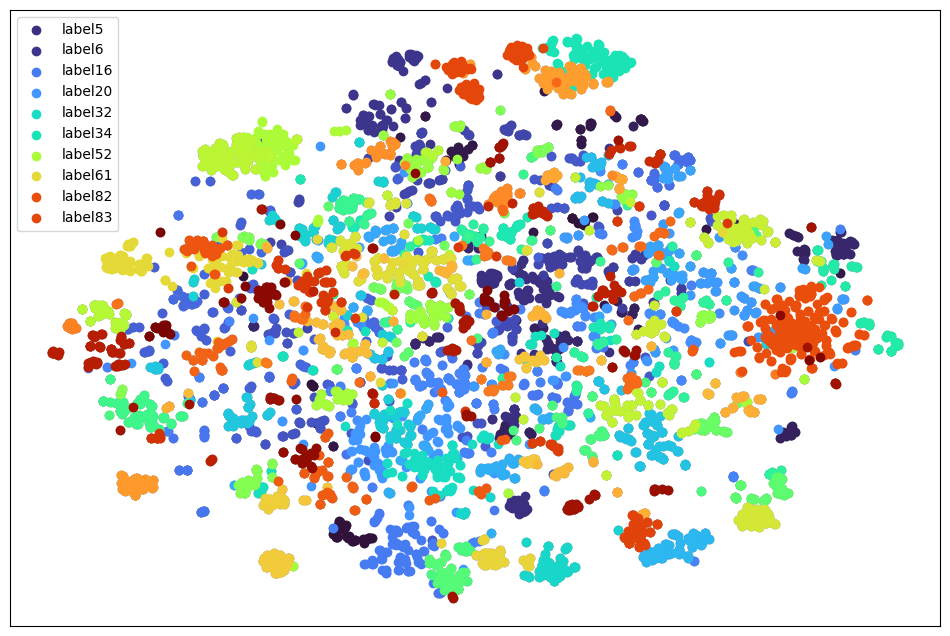

In [46]:
from sklearn.cluster import Birch
from tqdm import tqdm

# Run the BIRCH algorithm 
birch_model = Birch(n_clusters=100)
cluster_labels = birch_model.fit_predict(embeddings)

# Update k_optimal with the actual number of clusters found by BIRCH
cluster_count = len(set(cluster_labels))

# Make cluster to prompt map
cluster_to_prompt_birge = {}
for i in range(cluster_count):
    cluster_to_prompt_birge[i] = []
    for j in range(len(strings)):
        if cluster_labels[j] == i:
            cluster_to_prompt_birge[i].append(strings[j])

# Sort cluster to prompt map by length of prompts
cluster_to_prompt_birge_sorted = dict(sorted(cluster_to_prompt_birge.items(), key=lambda x: len(x[1]), reverse=True))
top_10_clusters = list(cluster_to_prompt_birge_sorted.keys())[:10]

# Make sure labels correspond to the number of clusters
labels = ["label"+str(i+1) for i in range(cluster_count)]  # Add your labels

# Now run the visualization using the cluster labels resulting from BIRCH
palette = plt.cm.get_cmap('turbo', cluster_count)  # 'tab10' provides nice distinct colors
plt.figure(figsize=(12, 8))

# Scatter plot with color coding for each cluster
for i in range(cluster_count): 
    if i not in top_10_clusters:
        plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], c="gray", alpha=1)

idx = 0
for i in range(cluster_count):
    if i in top_10_clusters:
        plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], label=labels[idx], c=[palette(idx)], alpha=1)
    else:
        plt.scatter(x_coords[cluster_labels == i], y_coords[cluster_labels == i], c=[palette(idx)], alpha=1)
    idx += 1

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 

plt.legend()

plt.savefig(f"images/{filename}_clusters.png")
plt.show()

In [16]:
cluster_count = len(set(cluster_labels))

# Make cluster to prompt map
cluster_to_prompt_birge = {}
for i in range(cluster_count):
    cluster_to_prompt_birge[i] = []
    for j in range(len(strings)):
        if cluster_labels[j] == i:
            cluster_to_prompt_birge[i].append(strings[j])

# Sort cluster to prompt map by length of prompts
cluster_to_prompt_birge_sorted = sorted(cluster_to_prompt_birge.items(), key=lambda x: len(x[1]), reverse=True)

from collections import Counter
lst = sorted([len(cluster_to_prompt_birge[i]) for i in range(cluster_count)], reverse=True)
bucket = sorted(Counter(lst).items(), key=lambda x: x[0], reverse=True)
print(bucket)

[(1139, 1), (985, 1), (588, 1), (526, 1), (447, 1), (295, 1), (275, 1), (252, 1), (247, 1), (172, 1)]


In [20]:
cluster_to_prompt_birge_sorted[0]

(1,
 ['Below you will find some examples for different store contexts and user preferences (this may differ from your own). These examples are meant to make you understand how to respond but using your OWN store context and user preferences given above.',
  'Lets go back',
  'is your email mikejones@gmail.com? I keep getting a "no delivered" error.',
  'The location given in the beginning should be very descriptive, but ',
  'Answer: NO\n',
  ': ',
  'Answer questions about a table of penguins and their attributes.',
  'Spot thrilling opportunities in the world of e-sports.',
  'Come along',
  'Ironman',
  'Aleksey Nikolayevich Andryunin a Male, aged 25.0, height 189.0 centimeters, Weight 100.0 kilograms, from team Russia-2 , participated in olympic games held in the year 2002 , for the Winter season, hosted in the city Salt Lake City in the Bobsleigh sporting category for the event Bobsleigh Mens Four but did not win any medal.',
  'I tried calling John at 9996582350, but no one picke